In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
import os

# Optionally force tensorflow on CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Table of Contents
1. [General Usage](#general-usage)
    1. [Basic Usage](#basic-usage)
    2. [Advanced Usage](#advanced-usage)
2. [Data Generation](#data-gen)
    1. [Model Synthesis](#model-synth)
        1. [Keras Synthesis](#keras-synth)
        2. [PyTorch Synthesis](#torch-synth)
    2. [Parallel Synthesis](#parallel-synth)
        1. [Randomly Generated Networks](#random-synth)
3. [Training Prediction Models](#train-models)
    1. [Parsing Datasets](#parse-data)
        1. [Reading from JSON](#read-json)
    2. [Training MLPs](#train-mlps)
        1. [Data Preprocessing](#mlp-data)
        2. [Building & Training](#fit-mlps)
    3. [Training Transformers](#train-transformers)
        1. [Data Preprocessing](#transformer-data)
        2. [Building & Training](#fit-transformers)
    4. [Finetuning (Optional)](#finetune)
        1. [Finetuning an MLP](#finetune-mlp)
        2. [Loading and Retraining](#load-tuner)
4. [Testing Prediction Models](#test-models)
    1. [Benchmark Networks](#benchmark-test)
    2. [Plots](#plots)
        1. [Box Plots](#box-plots)
        2. [Bar Plots](#bar-plots)

# 1. General Usage <a class="anchor" id="general-usage"></a>

## 1.1 Basic Usage <a class="anchor" id="basic-usage"></a>

In [ ]:
from keras.layers import Input, Dense, Activation
import keras

# Example of a keras Model to predict
input_size = 16
inputs = Input(shape=(input_size,))
x = Dense(32, activation="relu")(inputs)
x = Dense(32, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(5, activation="softmax")(x)

model_to_predict = keras.Model(inputs=inputs, outputs=outputs, name="Jet Classifier")
model_to_predict.build((None, input_size))

In [4]:
from rule4ml.models.estimators import MultiModelEstimator

# Load default estimator
estimator = MultiModelEstimator()
estimator.load_default_models()

In [ ]:
# MultiModelEstimator predictions are formatted as a DataFrame
prediction_df = estimator.predict(model_to_predict)

# each row is unique in the groupby, mean() is only called to convert DataFrameGroupBy into a nicely organized DataFrame
if not prediction_df.empty:
    prediction_df = prediction_df.groupby(
        ["Model", "Board", "Strategy", "Precision", "Reuse Factor"], observed=True
    ).mean()

prediction_df

In [ ]:
prediction_df.to_html("keras_example.html")

# prediction_df.to_latex("keras_example.tex")
# prediction_df.to_csv("keras_example.csv")
# prediction_df.to_json("keras_example.json")
# prediction_df.to_xml("keras_example.xml")

## 1.2 Advanced Usage <a class="anchor" id="advanced-usage"></a>

In [ ]:
import itertools

import keras
from keras.layers import Input, Dense
import torch

models_to_predict = []


# Example of a subclassed PyTorch model
class MyTopQuarks(torch.nn.Module):
    def __init__(self):
        super(MyTopQuarks, self).__init__()

        self.dense1 = torch.nn.Linear(10, 32)
        self.relu = torch.nn.ReLU()
        self.dense2 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, inputs):
        x = self.dense1(inputs)
        x = self.relu(x)
        x = self.dense2(x)
        outputs = self.sigmoid(x)

        return outputs


models_to_predict.append(MyTopQuarks())

# Example of a keras Sequential model
input_size = 16
model_to_predict = keras.Sequential(
    layers=[
        keras.layers.Input(shape=(input_size,)),
        keras.layers.Dense(32, use_bias=True),
        keras.layers.Activation("relu"),
        keras.layers.Dense(32, use_bias=True),
        keras.layers.Activation("relu"),
        keras.layers.Dense(32, use_bias=True),
        keras.layers.Activation("relu"),
        keras.layers.Dense(5, use_bias=True),
        keras.layers.Activation("softmax"),
    ],
    name="Jet Classifier",
)
model_to_predict.build((None, input_size))

models_to_predict.append(model_to_predict)

hls_configs = [
    {
        "model": {
            "precision": "ap_fixed<8, 3>",
            "reuse_factor": 32,
            "strategy": strategy,
        },
        "board": board,
    }
    for board, strategy in itertools.product(["pynq-z2", "zcu102"], ["Latency", "Resource"])
]

In [ ]:
from rule4ml.models.estimators import ModelWrapper

lut_model_wrapper = ModelWrapper()
lut_model_wrapper.load("./models/best_LUT_MLP_config.json", "./models/best_LUT_MLP.weights.h5")

lut_model_wrapper.predict(models_to_predict, hls_configs)

In [ ]:
from rule4ml.models.estimators import MultiModelEstimator

estimator = MultiModelEstimator()
estimator.add_model_wrapper(lut_model_wrapper)

estimator.predict(models_to_predict, hls_configs)

# 2. Data Generation <a class="anchor" id="data-gen"></a>

In [3]:
import os
import sys

# Specify Vivado path
os.environ["PATH"] = "/opt/Xilinx/Vivado/2019.1/bin:" + os.environ["PATH"]

base_path = os.path.join(os.getcwd(), "..", "data_gen")
sys.path.append(base_path)

## 2.1 Model Synthesis <a class="anchor" id="model-synth"></a>

### 2.1.1 Keras Model <a class="anchor" id="keras-synth"></a>

In [ ]:
import keras
from keras.layers import Input, Dense

from data_gen.nn_synth import synthesize_keras_model

input_size = 16
inputs = Input(shape=(input_size,))
x = Dense(32, activation="relu")(inputs)
x = Dense(32, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(5, activation="softmax")(x)

model_to_synthesize = keras.Model(inputs=inputs, outputs=outputs, name="Jet Classifier")
model_to_synthesize.build((None, input_size))

synthesis_result = synthesize_keras_model(
    model_to_synthesize,
    board="pynq-z2",
    strategy="Resource",
    precision="ap_fixed<8, 3>",
    reuse_factor=32,
    clock_period="10",
    io_type="io_parallel",
    project_dir="./hls4ml_prj",
    synth_uuid=None,
    verbose=0,
)

In [ ]:
from data_gen.utils import save_to_json

save_to_json(synthesis_result, "./synthesis_result.json")

### 2.1.2 PyTorch Model <a class="anchor" id="torch-synth"></a>

In [ ]:
import torch

from data_gen.nn_synth import synthesize_torch_model
from data_gen.utils import save_to_json

model_to_synthesize = torch.nn.Sequential(
    torch.nn.Linear(10, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
    torch.nn.Sigmoid(),
)

synthesis_result = synthesize_torch_model(
    model_to_synthesize,
    board="zcu102",
    strategy="Latency",
    precision="ap_fixed<8, 3>",
    reuse_factor=32,
    clock_period="10",
    io_type="io_parallel",
    project_dir="./hls4ml_prj",
    synth_uuid=None,
    verbose=0,
)

save_to_json(synthesis_result, "./synthesis_result.json")

## 2.2 Parallel Synthesis <a class="anchor" id="parallel-synth"></a>

### 2.2.1 Randomly Generated Networks <a class="anchor" id="random-synth"></a>

In [ ]:
from multiprocessing import Pool
import time

from data_gen.nn_gen import GeneratorSettings, generate_fc_network
from data_gen.nn_synth import (
    SynthSettings,
    synthesize_keras_model,
    parallel_generative_synthesis,
)

from data_gen.utils import IntRange, Power2Range, save_to_json

gen_settings = GeneratorSettings(
    input_range=Power2Range(16, 32),
    layer_range=IntRange(2, 3),
    neuron_range=Power2Range(16, 32),
    output_range=IntRange(1, 20),
    activations=["relu"],
)
synth_settings = SynthSettings(
    reuse_range=Power2Range(32, 64),
    precisions=["ap_fixed<2, 1>", "ap_fixed<8, 3>"],
    strategies=["Resource"],
)

n_procs = 3
with Pool(n_procs) as p:
    result = p.map_async(
        parallel_generative_synthesis,
        [
            {
                "job_id": f"{proc}",
                "n_models": 10,
                "project_dir": "./projects",
                "prj_overwrite": False,
                "save_path": "./",
                "rng_seed": 0,
                "gen_function": generate_fc_network,  # Keras only currently
                "gen_settings": gen_settings,
                "synth_function": synthesize_keras_model,
                "synth_settings": synth_settings,
            }
            for proc in range(1, n_procs + 1)
        ],
    )
    while not result.ready():
        time.sleep(1)
    result = result.get()
    p.terminate()
    p.join()

# 3. Training Prediction Models <a class="anchor" id="train-models"></a>

## 3.1 Parsing Datasets

### 3.1.1 Reading from JSON

In [17]:
from rule4ml.parsers.data_parser import (
    read_from_json,
    ParsedDataFilter,
    get_global_data,
    get_sequential_data,
    to_dataframe,
)

from rule4ml.parsers.data_parser import (
    default_board_map,
    default_strategy_map,
    default_layer_type_map,
)

# data_filter = ParsedDataFilter(
    # max_output_size=200,
# )

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
train_json_data = read_from_json(
    os.path.join("./wa-hls4ml_train_split.json"),
    # data_filter,
)
test_json_data = read_from_json(
    os.path.join("./wa-hls4ml_test_split.json"),
)

print(len(train_json_data))
print(len(test_json_data))

90313
22579


In [ ]:
json_data = read_from_json(
    os.path.join(base_path, "datasets", "wa-hls4ml_processed_vsynth_data.json"),
)
print(len(json_data))

In [4]:
meta_data, global_inputs, targets = get_global_data(json_data)
sequential_inputs = get_sequential_data(json_data)

# Ordinal encoding of categorical inputs
global_categorical_maps = {
    "strategy": default_strategy_map,
    "board": default_board_map,
}
sequential_categorical_maps = {
    "layer_type": default_layer_type_map,
}

In [5]:
df = to_dataframe(
    meta_data=meta_data,
    global_inputs=global_inputs,
    sequential_inputs=sequential_inputs,
    global_categorical_maps=global_categorical_maps,
    sequential_categorical_maps=sequential_categorical_maps,
    targets=targets,
)
df.head()

,uuid,model_name,artifacts_file,strategy,board,model_precision,model_total_bits,model_integer_bits,model_fractional_bits,global_reuse,reuse_mean,weight_total_bits,weight_integer_bits,weight_fractional_bits,dense_inputs_mean,dense_inputs_min,dense_inputs_min_idx,dense_inputs_max,dense_inputs_max_idx,dense_outputs_mean,dense_outputs_min,dense_outputs_min_idx,dense_outputs_max,dense_outputs_max_idx,dense_parameters_mean,dense_parameters_min,dense_parameters_min_idx,dense_parameters_max,dense_parameters_max_idx,dense_reuse_mean,dense_reuse_min,dense_reuse_min_idx,dense_reuse_max,dense_reuse_max_idx,dense_count,batchnormalization_inputs_mean,batchnormalization_inputs_min,batchnormalization_inputs_min_idx,batchnormalization_inputs_max,batchnormalization_inputs_max_idx,batchnormalization_outputs_mean,batchnormalization_outputs_min,batchnormalization_outputs_min_idx,batchnormalization_outputs_max,batchnormalization_outputs_max_idx,batchnormalization_parameters_mean,batchnormalization_parameters_min,batchnormalization_parameters_min_idx,batchnormalization_parameters_max,batchnormalization_parameters_max_idx,batchnormalization_count,add_inputs_mean,add_inputs_min,add_inputs_min_idx,add_inputs_max,add_inputs_max_idx,add_outputs_mean,add_outputs_min,add_outputs_min_idx,add_outputs_max,add_outputs_max_idx,add_count,concatenate_inputs_mean,concatenate_inputs_min,concatenate_inputs_min_idx,concatenate_inputs_max,concatenate_inputs_max_idx,concatenate_outputs_mean,concatenate_outputs_min,concatenate_outputs_min_idx,concatenate_outputs_max,concatenate_outputs_max_idx,concatenate_count,dropout_inputs_mean,dropout_inputs_min,dropout_inputs_min_idx,dropout_inputs_max,dropout_inputs_max_idx,dropout_outputs_mean,dropout_outputs_min,dropout_outputs_min_idx,dropout_outputs_max,dropout_outputs_max_idx,dropout_count,relu_inputs_mean,relu_inputs_min,relu_inputs_min_idx,relu_inputs_max,relu_inputs_max_idx,relu_outputs_mean,relu_outputs_min,relu_outputs_min_idx,relu_outputs_max,relu_outputs_max_idx,relu_count,sigmoid_inputs_mean,sigmoid_inputs_min,sigmoid_inputs_min_idx,sigmoid_inputs_max,sigmoid_inputs_max_idx,sigmoid_outputs_mean,sigmoid_outputs_min,sigmoid_outputs_min_idx,sigmoid_outputs_max,sigmoid_outputs_max_idx,sigmoid_count,tanh_inputs_mean,tanh_inputs_min,tanh_inputs_min_idx,tanh_inputs_max,tanh_inputs_max_idx,tanh_outputs_mean,tanh_outputs_min,tanh_outputs_min_idx,tanh_outputs_max,tanh_outputs_max_idx,tanh_count,softmax_inputs_mean,softmax_inputs_min,softmax_inputs_min_idx,softmax_inputs_max,softmax_inputs_max_idx,softmax_outputs_mean,softmax_outputs_min,softmax_outputs_min_idx,softmax_outputs_max,softmax_outputs_max_idx,softmax_count,total_mult,total_add,total_logical,total_lookup,sequential_inputs,bram,dsp,ff,lut,cycles
0,494ebda9-bf32-4ef4-ab88-47f1bd42e8e2,dense_88_56_112_6b,494ebda9-bf32-4ef4-ab88-47f1bd42e8e2.tar.gz,2,4,"ap_fixed<16,6>",16,6,10,3070,3070.0,6.0,1.0,5.0,72.0,56,3,88,1,84.0,56,1,112,3,5684.0,4984,1,6384,3,3070.0,3070,1,3070,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,181888,179552,0,0,layer_type layer_input_size layer_output_...,4.0,0.0,8633.0,7210.0,5604.0
1,e12136c3-e6ab-46cc-b580-c61df52fd715,dense_120_120_16_14b,e12136c3-e6ab-46cc-b580-c61df52fd715.tar.gz,2,4,"ap_fixed<16,6>",16,6,10,3070,3070.0,14.0,1.0,13.0,120.0,120,1,120,1,68.0,16,3,120,1,8228.0,1936,3,14520,1,3070.0,3070,1,3070,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,263296,259424,0,0,layer_type layer_input_size layer_output_...,8.5,6.0,14793.0,10267.0,4804.0
2,4dc5410c-baa9-4c43-97f0-20c11c48950b,dense_112_96_120_12b,4dc5410c-baa9-4c43-97f0-20c11c48950b.tar.gz,2,4,"ap_fixed<16,6>",16,6,10,2047,2047.0,12.0,1.0,11.0,104.0,96,3,112,1,108.0,96,1,120,3,11244.0,10848,1,11640,3,2047

In [6]:
df["sequential_inputs"].iloc[0]

,layer_type,layer_input_size,layer_output_size,layer_parameter_count,layer_reuse
0,2,88,56,4984,3070
1,2,56,112,6384,3070
2,0,0,0,0,0
3,0,0,0,0,0


In [7]:
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import numpy as np

seed_num = 1337
np.random.seed(seed_num)
keras.utils.set_random_seed(seed_num)
tf.config.experimental.enable_op_determinism()

train_df, test_df = train_test_split(df, test_size=0.20, random_state=seed_num)
print(f"Train Dataframe: {train_df.shape}")
print(f"Test Dataframe: {test_df.shape}")

2024-10-02 15:59:37.757016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 15:59:37.757042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 15:59:37.758024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 15:59:37.763020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 15:59:38.244622: W tensorflow/compiler/tf2

Train Dataframe: (90313, 138)
Test Dataframe: (22579, 138)


In [16]:
import os, json

def save_to_json(data, file_path="./dataset.json", indent=2):
    """
    _summary_

    Args:
        data (_type_): _description_
        file_path (str, optional): _description_. Defaults to './dataset.json'.
        indent (int, optional): _description_. Defaults to 2.
    """

    if not os.path.isfile(file_path):  # Create file if it doesn't exist
        with open(file_path, "w") as json_file:
            json.dump([data], json_file, indent=indent)
    else:  # If it exists then just append to the file
        with open(file_path, "r+") as json_file:
            json_file.seek(os.stat(file_path).st_size - 2)
            json_file.write(
                ",\n"
                + " " * indent
                + "{}\n]".format(json.dumps(data, indent=indent).replace("\n", "\n" + " " * indent))
            )

# split and save a json file using the uuids in the test dataframe
for data in json_data:
    if data["meta_data"]["uuid"] in train_df["uuid"].values:
        save_to_json(data, f"./wa-hls4ml_train_split.json")
    if data["meta_data"]["uuid"] in test_df["uuid"].values:
        save_to_json(data, f"./wa-hls4ml_test_split.json")


## 3.2 Training MLPs <a class="anchor" id="train-mlps"></a>

### 3.2.1 Data Preprocessing <a class="anchor" id="mlp-data"></a>

In [8]:
feature_labels = [  # Selecting input features
    "strategy",
    "board",
    # "precision",
    # "model_total_bits",
    # "model_integer_bits",
    # "model_fractional_bits",
    "reuse_mean",
    "weight_total_bits",
    # "weight_integer_bits",
    # "weight_fractional_bits",
    # "dense_count",
    # "batchnormalization_count",
    # "add_count",
    # "concatenate_count",
    # "dropout_count",
    # "relu_count",
    # "sigmoid_count",
    # "tanh_count",
    # "softmax_count",
    # "dense_parameters_mean",
    # "dense_inputs_mean",
    # "dense_outputs_mean",
    # "dense_reuse_mean",
    "dense_inputs_mean",
    # "dense_inputs_min",
    # "dense_inputs_min_idx",
    # "dense_inputs_max",
    # "dense_inputs_max_idx",
    "dense_outputs_mean",
    # "dense_outputs_min",
    # "dense_outputs_min_idx",
    # "dense_outputs_max",
    # "dense_outputs_max_idx",
    "dense_parameters_mean",
    # "dense_parameters_min",
    # "dense_parameters_min_idx",
    # "dense_parameters_max",
    # "dense_parameters_max_idx",
    "dense_reuse_mean",
    # "dense_reuse_min",
    # "dense_reuse_min_idx",
    # "dense_reuse_max",
    # "dense_reuse_max_idx",
    "dense_count",
    # "batchnormalization_inputs_mean",
    # "batchnormalization_inputs_min",
    # "batchnormalization_inputs_min_idx",
    # "batchnormalization_inputs_max",
    # "batchnormalization_inputs_max_idx",
    # "batchnormalization_outputs_mean",
    # "batchnormalization_outputs_min",
    # "batchnormalization_outputs_min_idx",
    # "batchnormalization_outputs_max",
    # "batchnormalization_outputs_max_idx",
    # "batchnormalization_parameters_mean",
    # "batchnormalization_parameters_min",
    # "batchnormalization_parameters_min_idx",
    # "batchnormalization_parameters_max",
    # "batchnormalization_parameters_max_idx",
    # "batchnormalization_count",
    # "add_inputs_mean",
    # "add_inputs_min",
    # "add_inputs_min_idx",
    # "add_inputs_max",
    # "add_inputs_max_idx",
    # "add_outputs_mean",
    # "add_outputs_min",
    # "add_outputs_min_idx",
    # "add_outputs_max",
    # "add_outputs_max_idx",
    # "add_count",
    # "concatenate_inputs_mean",
    # "concatenate_inputs_min",
    # "concatenate_inputs_min_idx",
    # "concatenate_inputs_max",
    # "concatenate_inputs_max_idx",
    # "concatenate_outputs_mean",
    # "concatenate_outputs_min",
    # "concatenate_outputs_min_idx",
    # "concatenate_outputs_max",
    # "concatenate_outputs_max_idx",
    # "concatenate_count",
    # "dropout_inputs_mean",
    # "dropout_inputs_min",
    # "dropout_inputs_min_idx",
    # "dropout_inputs_max",
    # "dropout_inputs_max_idx",
    # "dropout_outputs_mean",
    # "dropout_outputs_min",
    # "dropout_outputs_min_idx",
    # "dropout_outputs_max",
    # "dropout_outputs_max_idx",
    # "dropout_count",
    # "relu_inputs_mean",
    # "relu_inputs_min",
    # "relu_inputs_min_idx",
    # "relu_inputs_max",
    # "relu_inputs_max_idx",
    # "relu_outputs_mean",
    # "relu_outputs_min",
    # "relu_outputs_min_idx",
    # "relu_outputs_max",
    # "relu_outputs_max_idx",
    # "relu_count",
    # "sigmoid_inputs_mean",
    # "sigmoid_inputs_min",
    # "sigmoid_inputs_min_idx",
    # "sigmoid_inputs_max",
    # "sigmoid_inputs_max_idx",
    # "sigmoid_outputs_mean",
    # "sigmoid_outputs_min",
    # "sigmoid_outputs_min_idx",
    # "sigmoid_outputs_max",
    # "sigmoid_outputs_max_idx",
    # "sigmoid_count",
    # "tanh_inputs_mean",
    # "tanh_inputs_min",
    # "tanh_inputs_min_idx",
    # "tanh_inputs_max",
    # "tanh_inputs_max_idx",
    # "tanh_outputs_mean",
    # "tanh_outputs_min",
    # "tanh_outputs_min_idx",
    # "tanh_outputs_max",
    # "tanh_outputs_max_idx",
    # "tanh_count",
    # "softmax_inputs_mean",
    # "softmax_inputs_min",
    # "softmax_inputs_min_idx",
    # "softmax_inputs_max",
    # "softmax_inputs_max_idx",
    # "softmax_outputs_mean",
    # "softmax_outputs_min",
    # "softmax_outputs_min_idx",
    # "softmax_outputs_max",
    # "softmax_outputs_max_idx",
    # "softmax_count",
    # "total_mult",
    # "total_add",
    # "total_logical",
    # "total_lookup",
]

train_inputs_df = train_df[feature_labels].copy()
test_inputs_df = test_df[feature_labels].copy()

train_inputs_df.head()

,strategy,board,reuse_mean,weight_total_bits,dense_inputs_mean,dense_outputs_mean,dense_parameters_mean,dense_reuse_mean,dense_count
49874,2,4,1024.0,6.0,72.0,20.0,1236.0,1024.0,2
54842,2,4,3070.0,14.0,44.0,52.0,2100.0,3070.0,2
37149,2,4,1024.0,2.0,72.0,92.0,5916.0,1024.0,2
94625,2,4,4093.0,16.0,72.0,36.0,2468.0,4093.0,2
62657,2,4,1024.0,4.0,60.0,64.0,3232.0,1024.0,2


In [9]:
target_labels = ["lut"]

train_targets_df = train_df[target_labels].copy()
test_targets_df = test_df[target_labels].copy()

train_targets_df.head()

,lut
49874,2668.0
54842,5647.0
37149,11176.0
94625,5270.0
62657,8923.0


### 3.2.2 Building and Training <a class="anchor" id="fit-mlps"></a>

In [ ]:
from rule4ml.models.estimators import MLPSettings, ModelWrapper

input_shape = (None, len(train_inputs_df.columns))
output_shape = (None, len(train_targets_df.columns))

bram_mlp_settings = MLPSettings(
    embedding_outputs=[16 for _ in range(len(global_categorical_maps))],
    numerical_dense_layers=[32, 16, 32],
    dense_layers=[256, 256, 256, 64, 32, 64, 64],
    dense_dropouts=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
)
dsp_mlp_settings = MLPSettings(
    embedding_outputs=[16 for _ in range(len(global_categorical_maps))],
    numerical_dense_layers=[64, 32, 32],
    dense_layers=[256, 16, 32, 32, 64],
    dense_dropouts=[0.0, 0.0, 0.0, 0.0, 0.0],
)
ff_mlp_settings = MLPSettings(
    embedding_outputs=[16 for _ in range(len(global_categorical_maps))],
    numerical_dense_layers=[64, 16, 32],
    dense_layers=[64, 128, 64, 256, 32],
    dense_dropouts=[0.0, 0.0, 0.0, 0.0, 0.0],
)
lut_mlp_settings = MLPSettings(
    embedding_outputs=[16 for _ in range(len(global_categorical_maps))],
    numerical_dense_layers=[64, 16, 32, 32],
    dense_layers=[64, 128, 128, 64],
    dense_dropouts=[0.0, 0.0, 0.0, 0.0],
)
cycles_mlp_settings = MLPSettings(
    embedding_outputs=[16 for _ in range(len(global_categorical_maps))],
    numerical_dense_layers=[32, 16, 64],
    dense_layers=[256, 32, 32, 32, 256, 128, 128, 32, 16, 16, 64],
    dense_dropouts=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
)

vsynth_bram_mlp_settings = MLPSettings(
    embedding_outputs=[16, 4],
    numerical_dense_layers=[32, 16, 16, 16],
    dense_layers=[16, 16, 16, 16, 16, 16, 16, 16],
    dense_dropouts=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
)
vsynth_dsp_mlp_settings = MLPSettings(
    embedding_outputs=[16 for _ in range(len(global_categorical_maps))],
    numerical_dense_layers=[16, 256, 64, 256, 64],
    dense_layers=[16, 256, 128, 16, 16, 64],
    dense_dropouts=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
)
vsynth_ff_mlp_settings = MLPSettings(
    embedding_outputs=[16 for _ in range(len(global_categorical_maps))],
    numerical_dense_layers=[64, 256, 128, 16, 256],
    dense_layers=[64, 128, 128, 16, 32, 256, 64],
    dense_dropouts=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
)
vsynth_lut_mlp_settings = MLPSettings(
    embedding_outputs=[8, 16],
    numerical_dense_layers=[256],
    dense_layers=[64, 32, 16, 32, 32],
    dense_dropouts=[0.0, 0.0, 0.0, 0.0],
)
vsynth_cycles_mlp_settings = MLPSettings(
    embedding_outputs=[16 for _ in range(len(global_categorical_maps))],
    numerical_dense_layers=[64, 256, 128, 16, 256],
    dense_layers=[64, 128, 128, 16, 32, 256, 64],
    dense_dropouts=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
)

mlp_settings = vsynth_lut_mlp_settings

model_wrapper = ModelWrapper()
model_wrapper.build_mlp_model(
    mlp_settings,
    input_shape=input_shape,
    output_shape=output_shape,
    categorical_maps=global_categorical_maps,
    model_name=f"{'-'.join([x.upper() for x in target_labels])}_MLP",
    verbose=1,
)

In [11]:
from rule4ml.models.estimators import TrainSettings
from rule4ml.models.metrics import parametric_smape, parametric_r2

smape = parametric_smape(0, "-".join([x.upper() for x in target_labels]))
r2 = parametric_r2(0, "-".join([x.upper() for x in target_labels]))

bram_train_settings = TrainSettings(
    num_epochs=50,
    batch_size=64,
    learning_rate=1e-4,
    loss_function="mae",
    metrics=[smape, r2],
)
dsp_train_settings = TrainSettings(
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    loss_function="mae",
    metrics=[smape, r2],
)
ff_train_settings = TrainSettings(
    num_epochs=50,
    batch_size=64,
    learning_rate=1e-4,
    loss_function="mae",
    metrics=[smape, r2],
)
lut_train_settings = TrainSettings(
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    loss_function="mae",
    metrics=[smape, r2],
)
cycles_train_settings = TrainSettings(
    num_epochs=50,
    batch_size=64,
    learning_rate=1e-3,
    loss_function="mae",
    metrics=[smape, r2],
)

vsynth_bram_train_settings = TrainSettings(
    num_epochs=20,
    batch_size=128,
    learning_rate=1e-3,
    loss_function="msle",
    metrics=[smape, r2],
)
vsynth_dsp_train_settings = TrainSettings(
    num_epochs=20,
    batch_size=256,
    learning_rate=1e-4,
    loss_function="msle",
    metrics=[smape, r2],
)
vsynth_ff_train_settings = TrainSettings(
    num_epochs=20,
    batch_size=128,
    learning_rate=1e-4,
    loss_function="msle",
    metrics=[smape, r2],
)
vsynth_lut_train_settings = TrainSettings(
    num_epochs=20,
    batch_size=64,
    learning_rate=1e-3,
    loss_function="msle",
    metrics=[smape, r2],
)
vsynth_cycles_train_settings = TrainSettings(
    num_epochs=20,
    batch_size=128,
    learning_rate=1e-4,
    loss_function="msle",
    metrics=[smape, r2],
)

train_settings = vsynth_lut_train_settings

model_wrapper.build_dataset(
    train_inputs_df,
    train_targets_df,
    train_settings.batch_size,
    val_ratio=0.2,
    train_repeats=10,
    shuffle=True,
)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

from datetime import datetime

start_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./logs", f"{model_wrapper.model.name}_{start_time}")
checkpoint_dir = os.path.join("./checkpoints", f"{model_wrapper.model.name}_{start_time}")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_file = os.path.join(checkpoint_dir, f"{'-'.join(target_labels)}_best.weights.h5")

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=False,
    update_freq="epoch",
    embeddings_freq=1,
)

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)


def scheduler(epoch, lr):
    if (epoch + 1) % 20 == 0:
        return lr * np.exp(-0.2)
    return lr


lr_callback = LearningRateScheduler(scheduler)

callbacks = [
    tensorboard_callback,
    checkpoint_callback,
    # lr_callback
]

fit_history = model_wrapper.fit(train_settings, callbacks=callbacks, verbose=1)

In [14]:
model_wrapper.save("./models/vsynth")

## 3.3 Training Transformers <a class="anchor" id="train-transformers"></a>

### 3.3.1 Data Preprocessing <a class="anchor" id="transformer-data"></a>

In [ ]:
global_feature_labels = [
    "strategy",
    "board",
    "bit_width",
    "reuse_mean",
    "dense_inputs_mean",
    "dense_outputs_mean",
    "dense_parameters_mean",
    "dense_reuse_mean",
    "dense_count",
    "batchnormalization_inputs_mean",
    "batchnormalization_outputs_mean",
    "batchnormalization_parameters_mean",
    "batchnormalization_count",
    "add_count",
    "concatenate_count",
    "dropout_count",
    "relu_count",
    "sigmoid_count",
    "tanh_count",
    "softmax_inputs_mean",
    "softmax_outputs_mean",
    "softmax_count",
]
sequential_feature_labels = [
    "layer_type",
    "layer_input_size",
    "layer_output_size",
    "layer_parameter_count",
    "layer_reuse",
]

feature_labels = global_feature_labels
if len(sequential_feature_labels) > 0:
    feature_labels += ["sequential_inputs"]
inputs_df = df[feature_labels].copy()
inputs_df["sequential_inputs"] = inputs_df["sequential_inputs"].apply(
    lambda x: x[sequential_feature_labels]
)

inputs_df.head()

In [ ]:
inputs_df["sequential_inputs"].iloc[0]

In [ ]:
target_labels = ["lut"]
targets_df = df[target_labels].copy()
targets_df.head()

### 3.3.2 Building and Training <a class="anchor" id="fit-transformers"></a>

In [ ]:
from rule4ml.models.estimators import TransformerSettings, ModelWrapper

global_input_shape = (None, len(inputs_df.columns) - 1)  # not considering "sequential_inputs"
sequential_input_shape = (None, len(inputs_df["sequential_inputs"].iloc[0].columns))
output_shape = (None, len(targets_df.columns))

model_wrapper = ModelWrapper()
model_wrapper.build_transformer_model(
    TransformerSettings(
        global_dense_layers=[128, 192, 192],
        seq_dense_layers=[32, 64, 96],
        global_numerical_dense_layers=[16, 8],
        seq_numerical_dense_layers=[32],
        num_blocks=1,
        num_heads=8,
        ff_dim=256,
        output_dim=192,
        dropout_rate=0.2,
        embedding_outputs=[24, 24, 16, 8],
        dense_layers=[192, 128, 64, 32, 64, 128, 256, 32],
        dense_dropouts=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    ),
    global_input_shape=global_input_shape,
    sequential_input_shape=sequential_input_shape,
    output_shape=output_shape,
    global_categorical_maps=global_categorical_maps,
    sequential_categorical_maps=sequential_categorical_maps,
    model_name=f"{'-'.join([x.upper() for x in target_labels])}_Transformer",
    verbose=1,
)

In [ ]:
from rule4ml.models.estimators import TrainSettings

train_settings = TrainSettings(num_epochs=50)
model_wrapper.build_dataset(
    inputs_df,
    targets_df,
    train_settings.batch_size,
    val_ratio=0.15,
    train_repeats=1,
    shuffle=True,
)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

from datetime import datetime

start_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./logs", f"{model_wrapper.model.name}_{start_time}")
checkpoint_dir = os.path.join("./checkpoints", f"{model_wrapper.model.name}_{start_time}")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_file = os.path.join(checkpoint_dir, f"{'-'.join(target_labels)}_best.weights.h5")

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=False,
    update_freq="epoch",
    embeddings_freq=1,
)

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)


def scheduler(epoch, lr):
    if (epoch + 1) % 20 == 0:
        return lr * np.exp(-0.2)
    return lr


lr_callback = LearningRateScheduler(scheduler)

callbacks = [
    tensorboard_callback,
    checkpoint_callback,
    # lr_callback
]

fit_history = model_wrapper.fit(train_settings, callbacks=callbacks, verbose=1)

## 3.4 Finetuning (Optional) <a class="anchor" id="finetune"></a>

### 3.4.1 Finetuning an MLP <a class="anchor" id="finetune-mlp"></a>

In [ ]:
from rule4ml.models.tuning import Searcher
from rule4ml.models.estimators import ModelWrapper

target_labels = ["lut"]

train_targets_df = train_df[target_labels].copy()
test_targets_df = test_df[target_labels].copy()

model_wrapper = ModelWrapper()
searcher = Searcher(model_wrapper)
searcher.mlp_search(
    train_inputs_df,
    train_targets_df,
    global_categorical_maps,
    directory="./mlp_search",
    verbose=1,
)
searcher.tuner.results_summary()

### 3.4.2 Loading and Retraining <a class="anchor" id="load-tuner"></a>

In [ ]:
from rule4ml.models.tuning import Searcher
from rule4ml.models.estimators import ModelWrapper

model_wrapper = ModelWrapper()
searcher = Searcher(model_wrapper)
searcher.load_tuner(
    train_inputs_df,
    train_targets_df,
    global_categorical_maps,
    "./mlp_search",
    "20240930-040140",
)
searcher.tuner.results_summary()

In [ ]:
from rule4ml.models.estimators import TrainSettings

model_wrapper = searcher.model_wrapper
model_wrapper.fit(searcher.train_settings, verbose=1)

# 4. Testing Prediction Models <a class="anchor" id="test-models"></a>

## 4.1 Benchmark Networks <a class="anchor" id="benchmark-test"></a>

In [10]:
import keras
from keras.layers import (
    Dense,
    Add,
    Input,
    BatchNormalization,
    Conv2D,
    Flatten,
)


def get_test_model(name):
    model = None
    if name == "jet":
        input_size = 16
        inputs = Input(shape=(input_size,))
        x = Dense(32, use_bias=True)(inputs)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(5, use_bias=True)(x)
        outputs = Activation("softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "quarks":
        input_size = 10
        inputs = Input(shape=(input_size,))
        x = Dense(32, use_bias=True)(inputs)
        x = Activation("relu")(x)
        x = Dense(1, use_bias=True)(x)
        outputs = Activation("sigmoid")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "anomaly":
        input_size = 128
        inputs = Input(shape=(input_size,))
        x = Dense(8, use_bias=True)(inputs)
        x = Activation("relu")(x)
        x = Dense(4, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(128, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(4, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(128, use_bias=True)(x)
        outputs = Activation("softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "bipc":
        input_size = 36
        inputs = Input(shape=(input_size,))
        x = Dense(36, use_bias=False)(inputs)

        y = Activation("relu")(x)
        for i in range(5):
            y = Dense(36, use_bias=False)(y)
            y = Add()([x, y])
            y = Activation("relu")(y)
        outputs = y

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "cookie":
        input_size = 512
        inputs = Input(shape=(input_size,))
        x = Dense(4, use_bias=True)(inputs)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(5, use_bias=True)(x)
        outputs = Activation("softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "mnist":
        input_size = 784
        inputs = Input(shape=(input_size,))
        x = Dense(16, use_bias=True)(inputs)
        x = Activation("relu")(x)
        x = Dense(10, use_bias=True)(x)
        outputs = Activation("softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "automlp":
        input_size = 7
        inputs = Input(shape=(input_size,))
        x = Dense(12, use_bias=True)(inputs)
        x = Activation("relu")(x)
        x = Dense(16, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(12, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(2, use_bias=True)(x)
        outputs = Activation("softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "particle":
        input_size = 14
        inputs = Input(shape=(input_size,))
        x = Dense(32, use_bias=True)(inputs)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(3, use_bias=True)(x)
        outputs = Activation("softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "custom1":
        input_size = 16
        inputs = Input(shape=(input_size,))
        x = Dense(64, use_bias=True)(inputs)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(10, use_bias=True)(x)
        outputs = Activation("softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "custom2":
        input_size = 128
        inputs = Input(shape=(input_size,))
        x = Dense(16, use_bias=True)(inputs)
        x = Activation("relu")(x)
        x = Dense(64, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(64, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(32, use_bias=True)(x)
        x = Activation("relu")(x)
        x = Dense(50, use_bias=True)(x)
        outputs = Activation("softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "custom3":

        def residual_block(x, units):
            y = Dense(units)(x)
            y = BatchNormalization()(y)
            y = Activation("relu")(y)

            y = Dense(units)(y)
            y = BatchNormalization()(y)

            if x.shape[-1] == units:
                y = Add()([x, y])
            else:
                x = Dense(units)(x)
                x = BatchNormalization()(x)
                y = Add()([x, y])

            y = Activation("relu")(y)
            return y

        input_size = 64
        inputs = Input(shape=(input_size,))
        x = Dense(32, use_bias=True)(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = residual_block(x, units=32)
        x = residual_block(x, units=32)

        x = Dense(10)(x)
        outputs = Activation("softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    if name == "conv2d-nopool":
        input_size = (16, 16, 1)
        inputs = Input(input_size)
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = Conv2D(4, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Flatten()(x)
        x = Dense(2, use_bias=True)(x)
        outputs = Activation("softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name=name)
        model.build([None, input_size])

    return model

In [ ]:
from rule4ml.models.estimators import ModelWrapper, MultiModelEstimator
import itertools

hls_configs = [
    {
        "model": {
            "precision": "ap_fixed<8, 3>",
            "reuse_factor": 32,
            "strategy": strategy,
            "bram_factor": 1000000000,
            "trace_output": False,
        },
        "clock_period": 10.0,
        "io_type": "io_parallel",
        "board": board,
    }
    for board, strategy in itertools.product(["pynq-z2", "zcu102"], ["Latency", "Resource"])
]

model_names = [
    "jet",
    "quarks",
    "anomaly",
    "bipc",
    "cookie",
    "mnist",
    "automlp",
    "particle",
    "custom1",
    "custom2",
    "custom3",
]
models = [get_test_model(name) for name in model_names]

target_labels = ["bram", "dsp", "ff", "lut", "cycles"]

estimator = MultiModelEstimator()
for label in target_labels:
    model_wrapper = ModelWrapper()
    model_wrapper.load(
        f"./models/best_{label.upper()}_MLP_config.json",
        f"./models/best_{label.upper()}_MLP.weights.h5",
    )
    estimator.add_model_wrapper(model_wrapper)

prediction_df = estimator.predict(models, hls_configs)

In [ ]:
prediction_df.sort_values(["Board", "Strategy", "Reuse Factor"]).round(0)

## 4.2 Plots <a class="anchor" id="plots"></a>

### 4.2.1 Box Plots <a class="anchor" id="box-plots"></a>

In [52]:
import os
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import numpy as np

from rule4ml.parsers.data_parser import (
    read_from_json,
    ParsedDataFilter,
    get_global_data,
    get_sequential_data,
    to_dataframe,
)

from rule4ml.parsers.data_parser import (
    default_board_map,
    default_strategy_map,
    default_layer_type_map,
)

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
json_data = read_from_json(
    os.path.join(base_path, "datasets", "benchmark_vsynth_data.json"),
)

meta_data, global_inputs, targets = get_global_data(json_data)
sequential_inputs = get_sequential_data(json_data)

# Ordinal encoding of categorical inputs
global_categorical_maps = {
    "strategy": default_strategy_map,
    "board": default_board_map,
}
sequential_categorical_maps = {
    "layer_type": default_layer_type_map,
}

test_df = to_dataframe(
    meta_data=meta_data,
    global_inputs=global_inputs,
    sequential_inputs=sequential_inputs,
    global_categorical_maps=global_categorical_maps,
    sequential_categorical_maps=sequential_categorical_maps,
    targets=targets,
)

seed_num = 1337
np.random.seed(seed_num)
keras.utils.set_random_seed(seed_num)
tf.config.experimental.enable_op_determinism()

feature_labels = [
    "strategy",
    "board",
    # "precision",
    # "model_total_bits",
    # "model_integer_bits",
    # "model_fractional_bits",
    "reuse_mean",
    "weight_total_bits",
    # "weight_integer_bits",
    # "weight_fractional_bits",
    # "dense_count",
    # "batchnormalization_count",
    # "add_count",
    # "concatenate_count",
    # "dropout_count",
    # "relu_count",
    # "sigmoid_count",
    # "tanh_count",
    # "softmax_count",
    # "dense_parameters_mean",
    # "dense_inputs_mean",
    # "dense_outputs_mean",
    # "dense_reuse_mean",
    "dense_inputs_mean",
    # "dense_inputs_min",
    # "dense_inputs_min_idx",
    # "dense_inputs_max",
    # "dense_inputs_max_idx",
    "dense_outputs_mean",
    # "dense_outputs_min",
    # "dense_outputs_min_idx",
    # "dense_outputs_max",
    # "dense_outputs_max_idx",
    "dense_parameters_mean",
    # "dense_parameters_min",
    # "dense_parameters_min_idx",
    # "dense_parameters_max",
    # "dense_parameters_max_idx",
    "dense_reuse_mean",
    # "dense_reuse_min",
    # "dense_reuse_min_idx",
    # "dense_reuse_max",
    # "dense_reuse_max_idx",
    "dense_count",
    # "batchnormalization_inputs_mean",
    # "batchnormalization_inputs_min",
    # "batchnormalization_inputs_min_idx",
    # "batchnormalization_inputs_max",
    # "batchnormalization_inputs_max_idx",
    # "batchnormalization_outputs_mean",
    # "batchnormalization_outputs_min",
    # "batchnormalization_outputs_min_idx",
    # "batchnormalization_outputs_max",
    # "batchnormalization_outputs_max_idx",
    # "batchnormalization_parameters_mean",
    # "batchnormalization_parameters_min",
    # "batchnormalization_parameters_min_idx",
    # "batchnormalization_parameters_max",
    # "batchnormalization_parameters_max_idx",
    # "batchnormalization_count",
    # "add_inputs_mean",
    # "add_inputs_min",
    # "add_inputs_min_idx",
    # "add_inputs_max",
    # "add_inputs_max_idx",
    # "add_outputs_mean",
    # "add_outputs_min",
    # "add_outputs_min_idx",
    # "add_outputs_max",
    # "add_outputs_max_idx",
    # "add_count",
    # "concatenate_inputs_mean",
    # "concatenate_inputs_min",
    # "concatenate_inputs_min_idx",
    # "concatenate_inputs_max",
    # "concatenate_inputs_max_idx",
    # "concatenate_outputs_mean",
    # "concatenate_outputs_min",
    # "concatenate_outputs_min_idx",
    # "concatenate_outputs_max",
    # "concatenate_outputs_max_idx",
    # "concatenate_count",
    # "dropout_inputs_mean",
    # "dropout_inputs_min",
    # "dropout_inputs_min_idx",
    # "dropout_inputs_max",
    # "dropout_inputs_max_idx",
    # "dropout_outputs_mean",
    # "dropout_outputs_min",
    # "dropout_outputs_min_idx",
    # "dropout_outputs_max",
    # "dropout_outputs_max_idx",
    # "dropout_count",
    # "relu_inputs_mean",
    # "relu_inputs_min",
    # "relu_inputs_min_idx",
    # "relu_inputs_max",
    # "relu_inputs_max_idx",
    # "relu_outputs_mean",
    # "relu_outputs_min",
    # "relu_outputs_min_idx",
    # "relu_outputs_max",
    # "relu_outputs_max_idx",
    # "relu_count",
    # "sigmoid_inputs_mean",
    # "sigmoid_inputs_min",
    # "sigmoid_inputs_min_idx",
    # "sigmoid_inputs_max",
    # "sigmoid_inputs_max_idx",
    # "sigmoid_outputs_mean",
    # "sigmoid_outputs_min",
    # "sigmoid_outputs_min_idx",
    # "sigmoid_outputs_max",
    # "sigmoid_outputs_max_idx",
    # "sigmoid_count",
    # "tanh_inputs_mean",
    # "tanh_inputs_min",
    # "tanh_inputs_min_idx",
    # "tanh_inputs_max",
    # "tanh_inputs_max_idx",
    # "tanh_outputs_mean",
    # "tanh_outputs_min",
    # "tanh_outputs_min_idx",
    # "tanh_outputs_max",
    # "tanh_outputs_max_idx",
    # "tanh_count",
    # "softmax_inputs_mean",
    # "softmax_inputs_min",
    # "softmax_inputs_min_idx",
    # "softmax_inputs_max",
    # "softmax_inputs_max_idx",
    # "softmax_outputs_mean",
    # "softmax_outputs_min",
    # "softmax_outputs_min_idx",
    # "softmax_outputs_max",
    # "softmax_outputs_max_idx",
    # "softmax_count",
    # "total_mult",
    # "total_add",
    # "total_logical",
    # "total_lookup",
]

In [10]:
from rule4ml.models.estimators import ModelWrapper
from rule4ml.parsers.data_parser import boards_data, default_board_map

test_inputs_df = test_df[feature_labels].copy()
print(f"Test Inputs: {test_inputs_df.shape}")

prediction_labels = ["bram", "dsp", "ff", "lut", "cycles"]
test_targets_df = test_df[prediction_labels].copy()

wrappers = []
abs_errors = []
sape_errors = []
normed_errors = []
for label in prediction_labels:
    wrapper = ModelWrapper()
    # wrapper.load(
    #     f"./models/best_{label.upper()}_MLP_config.json",
    #     f"./models/best_{label.upper()}_MLP.weights.h5",
    # )
    wrapper.load(
        f"./models/vsynth/{label.upper()}_MLP_config.json",
        f"./models/vsynth/{label.upper()}_MLP.weights.h5",
    )
    wrappers.append(wrapper)

    pred = wrapper.predict_from_df(test_inputs_df).squeeze()
    gn = test_targets_df[label].values

    abs_errors.append(np.abs(gn - pred))
    sape_errors.append(2 * np.abs(gn - pred) / (np.abs(gn) + np.abs(pred) + 1e-6))

    board_name = ""
    for board, board_id in default_board_map.items():
        if board_id == test_inputs_df["board"].values[0]:
            board_name = board
            break

    if label != "cycles":
        max_vals = boards_data[board_name][f"max_{label}"]
        normed_gn = np.maximum(1 / max_vals, np.minimum(gn / max_vals, 2.0)) * 100
        normed_pred = np.maximum(1 / max_vals, np.minimum(pred / max_vals, 2.0)) * 100
        normed_errors.append(np.abs(normed_gn - normed_pred))
    else:
        normed_errors.append(np.abs(gn - pred))

Test Inputs: (22579, 9)


2024-10-02 15:59:39.026862: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-02 15:59:39.026883: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: 3it-ia-s001.3it.usherbrooke.ca
2024-10-02 15:59:39.026888: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: 3it-ia-s001.3it.usherbrooke.ca
2024-10-02 15:59:39.026933: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.90.7
2024-10-02 15:59:39.026949: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.90.7
2024-10-02 15:59:39.026953: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 550.90.7


In [11]:
np.asarray(abs_errors).shape

(5, 22579)

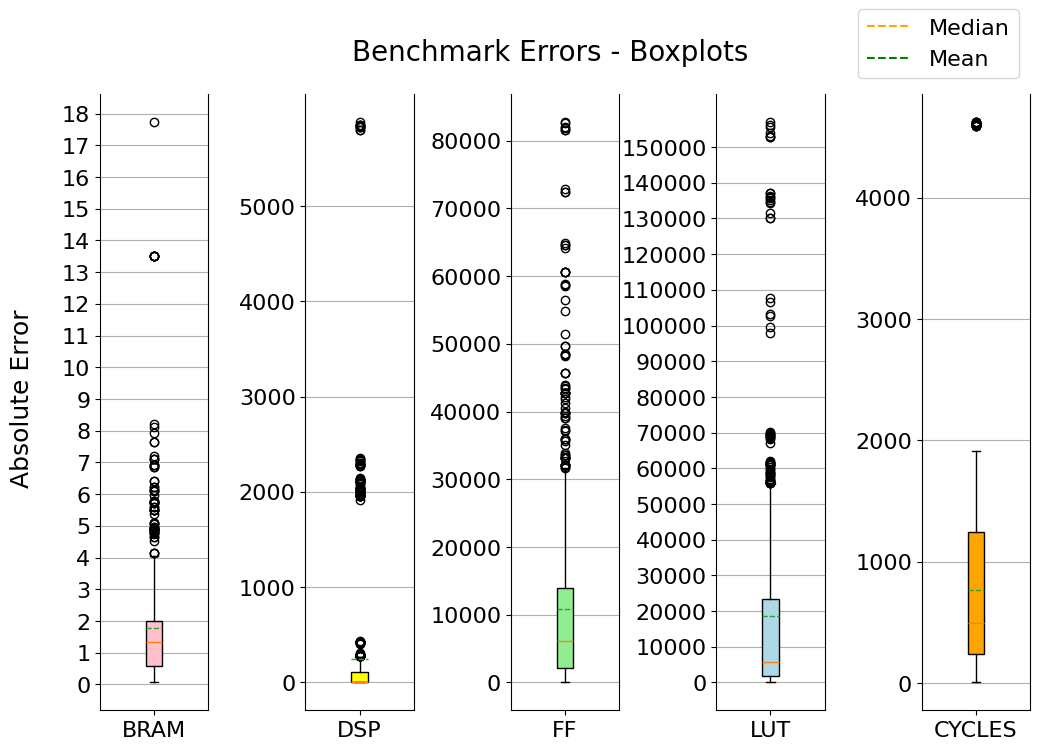

In [76]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({"font.size": 16})

fig, axis = plt.subplots(1, len(abs_errors), figsize=(12, 8))
axis = np.reshape(axis, -1)
fig.subplots_adjust(hspace=0.1, wspace=0.9)

iqr_weight = 1.5
colors = ["pink", "yellow", "lightgreen", "lightblue", "#FFA500"]

for i, errors in enumerate(abs_errors):
    label = prediction_labels[i]
    ax = axis[i]
    bplot = ax.boxplot(
        errors,
        whis=iqr_weight,
        tick_labels=[label.upper()],
        showfliers=True,
        showmeans=True,
        meanline=True,
        vert=True,
        patch_artist=True
    )

    for j, patch in enumerate(bplot["boxes"]):
        patch.set_facecolor(colors[(i + j) % len(colors)])

    # have more numbers of ticks than the original y-axis
    ax.set_yticks(np.arange(0, np.max(errors) + 1, 10**np.round(np.log10(np.max(errors) // 10))))

    ax.yaxis.grid(True)
    ax.spines.top.set_visible(False)
    ax.xaxis.tick_bottom()

median_line = Line2D([0], [0], color="orange", linestyle="--", linewidth=1.5, label="Median")
mean_line = Line2D([0], [0], color="green", linestyle="--", linewidth=1.5, label="Mean")

handles = [median_line, mean_line]
labels = ["Median", "Mean"]

legends = fig.legend(
    handles,
    labels,
    bbox_to_anchor=[0.9, 1],
    loc="upper right",
    ncol=len(labels) // 2,
)

ytext = fig.text(0.05, 0.5, "Absolute Error", va="center", rotation="vertical", size=18)
suptitle = fig.suptitle("Benchmark Errors - Boxplots", fontsize=20, y=0.95)

# fig.savefig(
#     "./box_plot_benchmark.png",
#     dpi=300,
#     bbox_extra_artists=(legends, ytext, suptitle),
#     bbox_inches="tight",
# )
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({"font.size": 16})

fig, axis = plt.subplots(2, 2, figsize=(12, 8), width_ratios=[3, 1])
axis = np.reshape(axis, -1)
fig.subplots_adjust(hspace=0.1, wspace=0.4)

flier_ax, box_ax = axis[0], axis[2]

iqr_weight = 1.5

resources_errors = prediction_errors[:4]
resources_labels = prediction_labels[:4]

threshold = 10.0
below_threshold = []
for errors in np.asarray(resources_errors):
    below_threshold.append(np.sum(errors < threshold) / len(errors))
print(f"Resources below {threshold}%: {below_threshold}")
print(f"Resources Mean: {np.mean(below_threshold)}")

bplot = box_ax.boxplot(
    resources_errors,
    whis=iqr_weight,
    tick_labels=[x.upper() for x in resources_labels],
    showfliers=True,
    showmeans=True,
    meanline=True,
    vert=True,
    patch_artist=True,
)
fliers = flier_ax.boxplot(
    resources_errors,
    whis=iqr_weight,
    tick_labels=["" for x in resources_labels],
    showfliers=True,
    showmeans=True,
    meanline=True,
    vert=True,
    patch_artist=True,
)

colors = ["pink", "yellow", "lightgreen", "lightblue", "FFA500"]
for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)

# box_ax.set_ylim(-1, 30)
# flier_ax.set_ylim(30, 200)

# box_ax.yaxis.grid(True)
# box_ax.spines.top.set_visible(False)
# box_ax.xaxis.tick_bottom()
# box_ax.set_yticks([0, 5, 10, 15, 20, 25, 30])

# flier_ax.yaxis.grid(True)
# flier_ax.spines.bottom.set_visible(False)
# flier_ax.xaxis.tick_top()
# flier_ax.set_yticks([30, 50, 75, 100, 125, 150, 175, 200])

d = 0.5
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
flier_ax.plot([0, 1], [0, 0], transform=flier_ax.transAxes, **kwargs)
box_ax.plot([0, 1], [1, 1], transform=box_ax.transAxes, **kwargs)

median_line = Line2D([0], [0], color="orange", linestyle="--", linewidth=1.5, label="Median")
mean_line = Line2D([0], [0], color="green", linestyle="--", linewidth=1.5, label="Mean")

handles = [median_line, mean_line]
labels = ["Median", "Mean"]

legends = fig.legend(
    handles,
    labels,
    bbox_to_anchor=[0.9, 1],
    # loc="upper left",
    loc="upper right",
    ncol=len(labels) // 2,
)

ytext = fig.text(0.06, 0.5, "Error (%)", va="center", rotation="vertical", size=18)
suptitle = fig.suptitle("Prediction Errors - Boxplots", fontsize=20, y=0.95)

latency_flier_ax, latency_box_ax = axis[1], axis[3]

iqr_weight = 1.5

latency_errors = [prediction_errors[4]]
latency_labels = [prediction_labels[4]]

threshold = 100.0
below_threshold = []
for errors in np.asarray(latency_errors):
    below_threshold.append(np.sum(errors < threshold) / len(errors))
print(f"Latency below {threshold} cycles: {below_threshold}")

latency_bplot = latency_box_ax.boxplot(
    latency_errors,
    whis=iqr_weight,
    widths=0.33,
    tick_labels=["Cycles"],
    showfliers=True,
    showmeans=True,
    meanline=True,
    vert=True,
    patch_artist=True,
)
latency_fliers = latency_flier_ax.boxplot(
    latency_errors,
    whis=iqr_weight,
    widths=0.33,
    tick_labels=["" for x in latency_labels],
    showfliers=True,
    showmeans=True,
    meanline=True,
    vert=True,
    patch_artist=True,
)

colors = ["lightblue"]
for patch, color in zip(latency_bplot["boxes"], colors):
    patch.set_facecolor(color)

latency_box_ax.set_ylim(-10, 200)
latency_flier_ax.set_ylim(200, 650)

latency_box_ax.yaxis.grid(True)
latency_box_ax.spines.top.set_visible(False)
latency_box_ax.xaxis.tick_bottom()
latency_box_ax.set_yticks(np.arange(0, 225, 25))

latency_flier_ax.yaxis.grid(True)
latency_flier_ax.spines.bottom.set_visible(False)
latency_flier_ax.xaxis.tick_top()
latency_flier_ax.set_yticks(np.arange(200, 700, 100))

d = 0.5
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
latency_flier_ax.plot([0, 1], [0, 0], transform=latency_flier_ax.transAxes, **kwargs)
latency_box_ax.plot([0, 1], [1, 1], transform=latency_box_ax.transAxes, **kwargs)

latency_ytext = fig.text(0.66, 0.5, "Error (Cycles)", va="center", rotation="vertical", size=18)

resource_caption = fig.text(0.355, 0.04, "(a)", va="center", size=18)
latency_caption = fig.text(0.808, 0.04, "(b)", va="center", size=18)

# fig.savefig(
#     "/mnt/c/Users/Y540/Desktop/box_plot_merged.jpg",
#     dpi=300,
#     bbox_extra_artists=(legends, ytext, suptitle, latency_ytext, resource_caption, latency_caption),
#     bbox_inches="tight",
# )
plt.show()

### 4.2.2 Bar Plots <a class="anchor" id="bar-plots"></a>

In [47]:
from rule4ml.models.estimators import ModelWrapper, MultiModelEstimator
import numpy as np
import itertools

from rule4ml.parsers.data_parser import read_from_json

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
json_data = read_from_json(
    os.path.join(base_path, "datasets", "benchmark_vsynth_data.json")
)

meta_data, global_inputs, targets = get_global_data(json_data)
sequential_inputs = get_sequential_data(json_data)

# Ordinal encoding of categorical inputs
global_categorical_maps = {
    "strategy": default_strategy_map,
    "board": default_board_map,
}
sequential_categorical_maps = {
    "layer_type": default_layer_type_map,
}

benchmark_df = to_dataframe(
    meta_data=meta_data,
    global_inputs=global_inputs,
    sequential_inputs=sequential_inputs,
    global_categorical_maps=global_categorical_maps,
    sequential_categorical_maps=sequential_categorical_maps,
    targets=targets,
)
benchmark_inputs_df = benchmark_df[feature_labels].copy()

prediction_labels = ["bram", "dsp", "ff", "lut", "cycles"]
benchmark_targets_df = benchmark_df[prediction_labels].copy()

benchmark_merged_df = benchmark_df.copy().drop(columns=prediction_labels, axis=1)
for label in prediction_labels:
    wrapper = ModelWrapper()
    wrapper.load(
        f"./models/vsynth/{label.upper()}_MLP_config.json",
        f"./models/vsynth/{label.upper()}_MLP.weights.h5",
    )

    benchmark_merged_df[f"{label.upper()}_G"] = benchmark_targets_df[label].values
    benchmark_merged_df[f"{label.upper()}_P"] = wrapper.predict_from_df(benchmark_inputs_df).squeeze()

In [48]:
benchmark_merged_df.head()

,uuid,model_name,artifacts_file,strategy,board,model_precision,model_total_bits,model_integer_bits,model_fractional_bits,global_reuse,reuse_mean,weight_total_bits,weight_integer_bits,weight_fractional_bits,dense_inputs_mean,dense_inputs_min,dense_inputs_min_idx,dense_inputs_max,dense_inputs_max_idx,dense_outputs_mean,dense_outputs_min,dense_outputs_min_idx,dense_outputs_max,dense_outputs_max_idx,dense_parameters_mean,dense_parameters_min,dense_parameters_min_idx,dense_parameters_max,dense_parameters_max_idx,dense_reuse_mean,dense_reuse_min,dense_reuse_min_idx,dense_reuse_max,dense_reuse_max_idx,dense_count,batchnormalization_inputs_mean,batchnormalization_inputs_min,batchnormalization_inputs_min_idx,batchnormalization_inputs_max,batchnormalization_inputs_max_idx,batchnormalization_outputs_mean,batchnormalization_outputs_min,batchnormalization_outputs_min_idx,batchnormalization_outputs_max,batchnormalization_outputs_max_idx,batchnormalization_parameters_mean,batchnormalization_parameters_min,batchnormalization_parameters_min_idx,batchnormalization_parameters_max,batchnormalization_parameters_max_idx,batchnormalization_count,add_inputs_mean,add_inputs_min,add_inputs_min_idx,add_inputs_max,add_inputs_max_idx,add_outputs_mean,add_outputs_min,add_outputs_min_idx,add_outputs_max,add_outputs_max_idx,add_count,concatenate_inputs_mean,concatenate_inputs_min,concatenate_inputs_min_idx,concatenate_inputs_max,concatenate_inputs_max_idx,concatenate_outputs_mean,concatenate_outputs_min,concatenate_outputs_min_idx,concatenate_outputs_max,concatenate_outputs_max_idx,concatenate_count,dropout_inputs_mean,dropout_inputs_min,dropout_inputs_min_idx,dropout_inputs_max,dropout_inputs_max_idx,dropout_outputs_mean,dropout_outputs_min,dropout_outputs_min_idx,dropout_outputs_max,dropout_outputs_max_idx,dropout_count,relu_inputs_mean,relu_inputs_min,relu_inputs_min_idx,relu_inputs_max,relu_inputs_max_idx,relu_outputs_mean,relu_outputs_min,relu_outputs_min_idx,relu_outputs_max,relu_outputs_max_idx,relu_count,sigmoid_inputs_mean,sigmoid_inputs_min,sigmoid_inputs_min_idx,sigmoid_inputs_max,sigmoid_inputs_max_idx,sigmoid_outputs_mean,sigmoid_outputs_min,sigmoid_outputs_min_idx,sigmoid_outputs_max,sigmoid_outputs_max_idx,sigmoid_count,tanh_inputs_mean,tanh_inputs_min,tanh_inputs_min_idx,tanh_inputs_max,tanh_inputs_max_idx,tanh_outputs_mean,tanh_outputs_min,tanh_outputs_min_idx,tanh_outputs_max,tanh_outputs_max_idx,tanh_count,softmax_inputs_mean,softmax_inputs_min,softmax_inputs_min_idx,softmax_inputs_max,softmax_inputs_max_idx,softmax_outputs_mean,softmax_outputs_min,softmax_outputs_min_idx,softmax_outputs_max,softmax_outputs_max_idx,softmax_count,total_mult,total_add,total_logical,total_lookup,sequential_inputs,BRAM_G,BRAM_P,DSP_G,DSP_P,FF_G,FF_P,LUT_G,LUT_P,CYCLES_G,CYCLES_P
0,12d641dd-5146-4c9f-911d-cf810823fff7,Jet_2b_1024rf_R,12d641dd-5146-4c9f-911d-cf810823fff7.tar.gz,2,4,"ap_fixed<2, 1>",2,1,1,1024,918.153846,2.0,1.0,1.0,28.0,16,2,32,5,25.25,5,11,32,2,705.25,165,11,1056,5,680.0,160,11,1024,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32.000000,32,4,32,4,32.000000,32,4,32,4,3,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,5,13,5,13,5.0,5,13,5,13,1,5652,5418,192,6,layer_type layer_input_size layer_output...,2.0,1.628390,5.0,0.000000,2898.0,2031.187988,3133.0,2754.889893,2762.0,1422.283447
1,e89c3f49-0a65-47bb-8ace-4c65db6d108b,Bipc_8b_1024rf_R,e89c3f49-0a65-47bb-8ace-4c65db6d108b.tar.gz,2,4,"ap_fixed<8, 3>",8,3,5,1024,1092.000000,8.0,3.0,5.0,36.0,36,2,36,2,36.00,36,2,36,2,1296.00,1296,2,1296,2,1296.0,1296,2,1296,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1296.0,1296,7,1296,7,36.0,36,7,36,7,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.000000,36,4,36,4,36.000000,36,4,36,4,6,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,62208,112320,1728,0,layer_type layer_input_size layer_output...,5.0,1.926896,0.0,4.054204,23944.0,5129.657227,21260.0,3610.049072,6578.5,1978.667236


In [49]:
precision_order = ["ap_fixed<2, 1>", "ap_fixed<8, 3>", "ap_fixed<16, 6>"]
benchmark_merged_df["model_precision"] = pd.Categorical(
    benchmark_merged_df["model_precision"], categories=precision_order, ordered=True
)

benchmark_merged_df.head()

,uuid,model_name,artifacts_file,strategy,board,model_precision,model_total_bits,model_integer_bits,model_fractional_bits,global_reuse,reuse_mean,weight_total_bits,weight_integer_bits,weight_fractional_bits,dense_inputs_mean,dense_inputs_min,dense_inputs_min_idx,dense_inputs_max,dense_inputs_max_idx,dense_outputs_mean,dense_outputs_min,dense_outputs_min_idx,dense_outputs_max,dense_outputs_max_idx,dense_parameters_mean,dense_parameters_min,dense_parameters_min_idx,dense_parameters_max,dense_parameters_max_idx,dense_reuse_mean,dense_reuse_min,dense_reuse_min_idx,dense_reuse_max,dense_reuse_max_idx,dense_count,batchnormalization_inputs_mean,batchnormalization_inputs_min,batchnormalization_inputs_min_idx,batchnormalization_inputs_max,batchnormalization_inputs_max_idx,batchnormalization_outputs_mean,batchnormalization_outputs_min,batchnormalization_outputs_min_idx,batchnormalization_outputs_max,batchnormalization_outputs_max_idx,batchnormalization_parameters_mean,batchnormalization_parameters_min,batchnormalization_parameters_min_idx,batchnormalization_parameters_max,batchnormalization_parameters_max_idx,batchnormalization_count,add_inputs_mean,add_inputs_min,add_inputs_min_idx,add_inputs_max,add_inputs_max_idx,add_outputs_mean,add_outputs_min,add_outputs_min_idx,add_outputs_max,add_outputs_max_idx,add_count,concatenate_inputs_mean,concatenate_inputs_min,concatenate_inputs_min_idx,concatenate_inputs_max,concatenate_inputs_max_idx,concatenate_outputs_mean,concatenate_outputs_min,concatenate_outputs_min_idx,concatenate_outputs_max,concatenate_outputs_max_idx,concatenate_count,dropout_inputs_mean,dropout_inputs_min,dropout_inputs_min_idx,dropout_inputs_max,dropout_inputs_max_idx,dropout_outputs_mean,dropout_outputs_min,dropout_outputs_min_idx,dropout_outputs_max,dropout_outputs_max_idx,dropout_count,relu_inputs_mean,relu_inputs_min,relu_inputs_min_idx,relu_inputs_max,relu_inputs_max_idx,relu_outputs_mean,relu_outputs_min,relu_outputs_min_idx,relu_outputs_max,relu_outputs_max_idx,relu_count,sigmoid_inputs_mean,sigmoid_inputs_min,sigmoid_inputs_min_idx,sigmoid_inputs_max,sigmoid_inputs_max_idx,sigmoid_outputs_mean,sigmoid_outputs_min,sigmoid_outputs_min_idx,sigmoid_outputs_max,sigmoid_outputs_max_idx,sigmoid_count,tanh_inputs_mean,tanh_inputs_min,tanh_inputs_min_idx,tanh_inputs_max,tanh_inputs_max_idx,tanh_outputs_mean,tanh_outputs_min,tanh_outputs_min_idx,tanh_outputs_max,tanh_outputs_max_idx,tanh_count,softmax_inputs_mean,softmax_inputs_min,softmax_inputs_min_idx,softmax_inputs_max,softmax_inputs_max_idx,softmax_outputs_mean,softmax_outputs_min,softmax_outputs_min_idx,softmax_outputs_max,softmax_outputs_max_idx,softmax_count,total_mult,total_add,total_logical,total_lookup,sequential_inputs,BRAM_G,BRAM_P,DSP_G,DSP_P,FF_G,FF_P,LUT_G,LUT_P,CYCLES_G,CYCLES_P
0,12d641dd-5146-4c9f-911d-cf810823fff7,Jet_2b_1024rf_R,12d641dd-5146-4c9f-911d-cf810823fff7.tar.gz,2,4,"ap_fixed<2, 1>",2,1,1,1024,918.153846,2.0,1.0,1.0,28.0,16,2,32,5,25.25,5,11,32,2,705.25,165,11,1056,5,680.0,160,11,1024,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32.000000,32,4,32,4,32.000000,32,4,32,4,3,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,5,13,5,13,5.0,5,13,5,13,1,5652,5418,192,6,layer_type layer_input_size layer_output...,2.0,1.628390,5.0,0.000000,2898.0,2031.187988,3133.0,2754.889893,2762.0,1422.283447
1,e89c3f49-0a65-47bb-8ace-4c65db6d108b,Bipc_8b_1024rf_R,e89c3f49-0a65-47bb-8ace-4c65db6d108b.tar.gz,2,4,"ap_fixed<8, 3>",8,3,5,1024,1092.000000,8.0,3.0,5.0,36.0,36,2,36,2,36.00,36,2,36,2,1296.00,1296,2,1296,2,1296.0,1296,2,1296,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1296.0,1296,7,1296,7,36.0,36,7,36,7,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.000000,36,4,36,4,36.000000,36,4,36,4,6,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,62208,112320,1728,0,layer_type layer_input_size layer_output...,5.0,1.926896,0.0,4.054204,23944.0,5129.657227,21260.0,3610.049072,6578.5,1978.667236


In [50]:
reverse_strategy_map = {v: k for k, v in default_strategy_map.items()}
reverse_board_map = {v: k for k, v in default_board_map.items()}

benchmark_merged_df["strategy"] = benchmark_merged_df["strategy"].map(reverse_strategy_map)
benchmark_merged_df["board"] = benchmark_merged_df["board"].map(reverse_board_map)

prediction_grouped_mean = (
    benchmark_merged_df.groupby(["strategy", "board", "weight_total_bits", "global_reuse"])[
        [
            "BRAM_G",
            "BRAM_P",
            # "DSP_G",
            # "DSP_P",
            # "FF_G",
            # "FF_P",
            # "LUT_G",
            # "LUT_P",
            # "CYCLES_G",
            # "CYCLES_P"
        ]
    ]
    .mean()
)
prediction_grouped_mean

BRAM_G    BRAM_P
strategy board      weight_total_bits global_reuse                    
latency  alveo-u200 2.0               1             0.000000  1.331558
                                      128           0.000000  1.316507
                                      1024          0.000000  1.055184
                    8.0               1             1.520000  1.882050
                                      128           1.560000  1.661192
                                      1024          1.576923  0.952595
                    16.0              1             1.653846  2.270959
                                      128           1.720000  2.165776
                                      1024          1.458333  1.073592
         alveo-u250 2.0               1             0.000000  1.330441
                                      128           0.000000  1.330179
                                      1024          0.000000  0.961532
                    8.0               1             1.666667  1.778495
                                      128           1.833333  1.603372
                                      1024          1.826087  0.891881
                    16.0              1             1.653846  2.234507
                                      128           1.576923  2.029458
                                      1024          1.772727  1.065355
resource alveo-u200 2.0               1             2.545455  1.467663
                                      128           0.821429  1.502518
                                      1024          1.769231  1.136491
                    8.0               1             1.800000  1.459245
                                      128           3.750000  1.349998
                                      1024          3.166667  0.963154
                    16.0              1             1.760000  2.119329
                                      128           4.964286  1.985727
                                      1024          3.200000  1.078285
         alveo-u250 2.0               1             1.217391  1.631657
                                      128           0.875000  1.601818
                                      1024          1.703704  1.133645
                    8.0               1             2.375000  1.538255
                                      128           4.320000  1.478849
                                      1024          3.458333  0.977772
                    16.0              1             1.636364  1.876362
                                      128           4.478261  1.716609
                                      1024          2.960000  0.978689

/tmp/ipykernel_1982034/1869560206.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gn_vals[j],
/tmp/ipykernel_1982034/1869560206.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_vals[j],
/tmp/ipykernel_1982034/1869560206.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gn_vals[j],
/tmp/ipykernel_1982034/1869560206.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version,

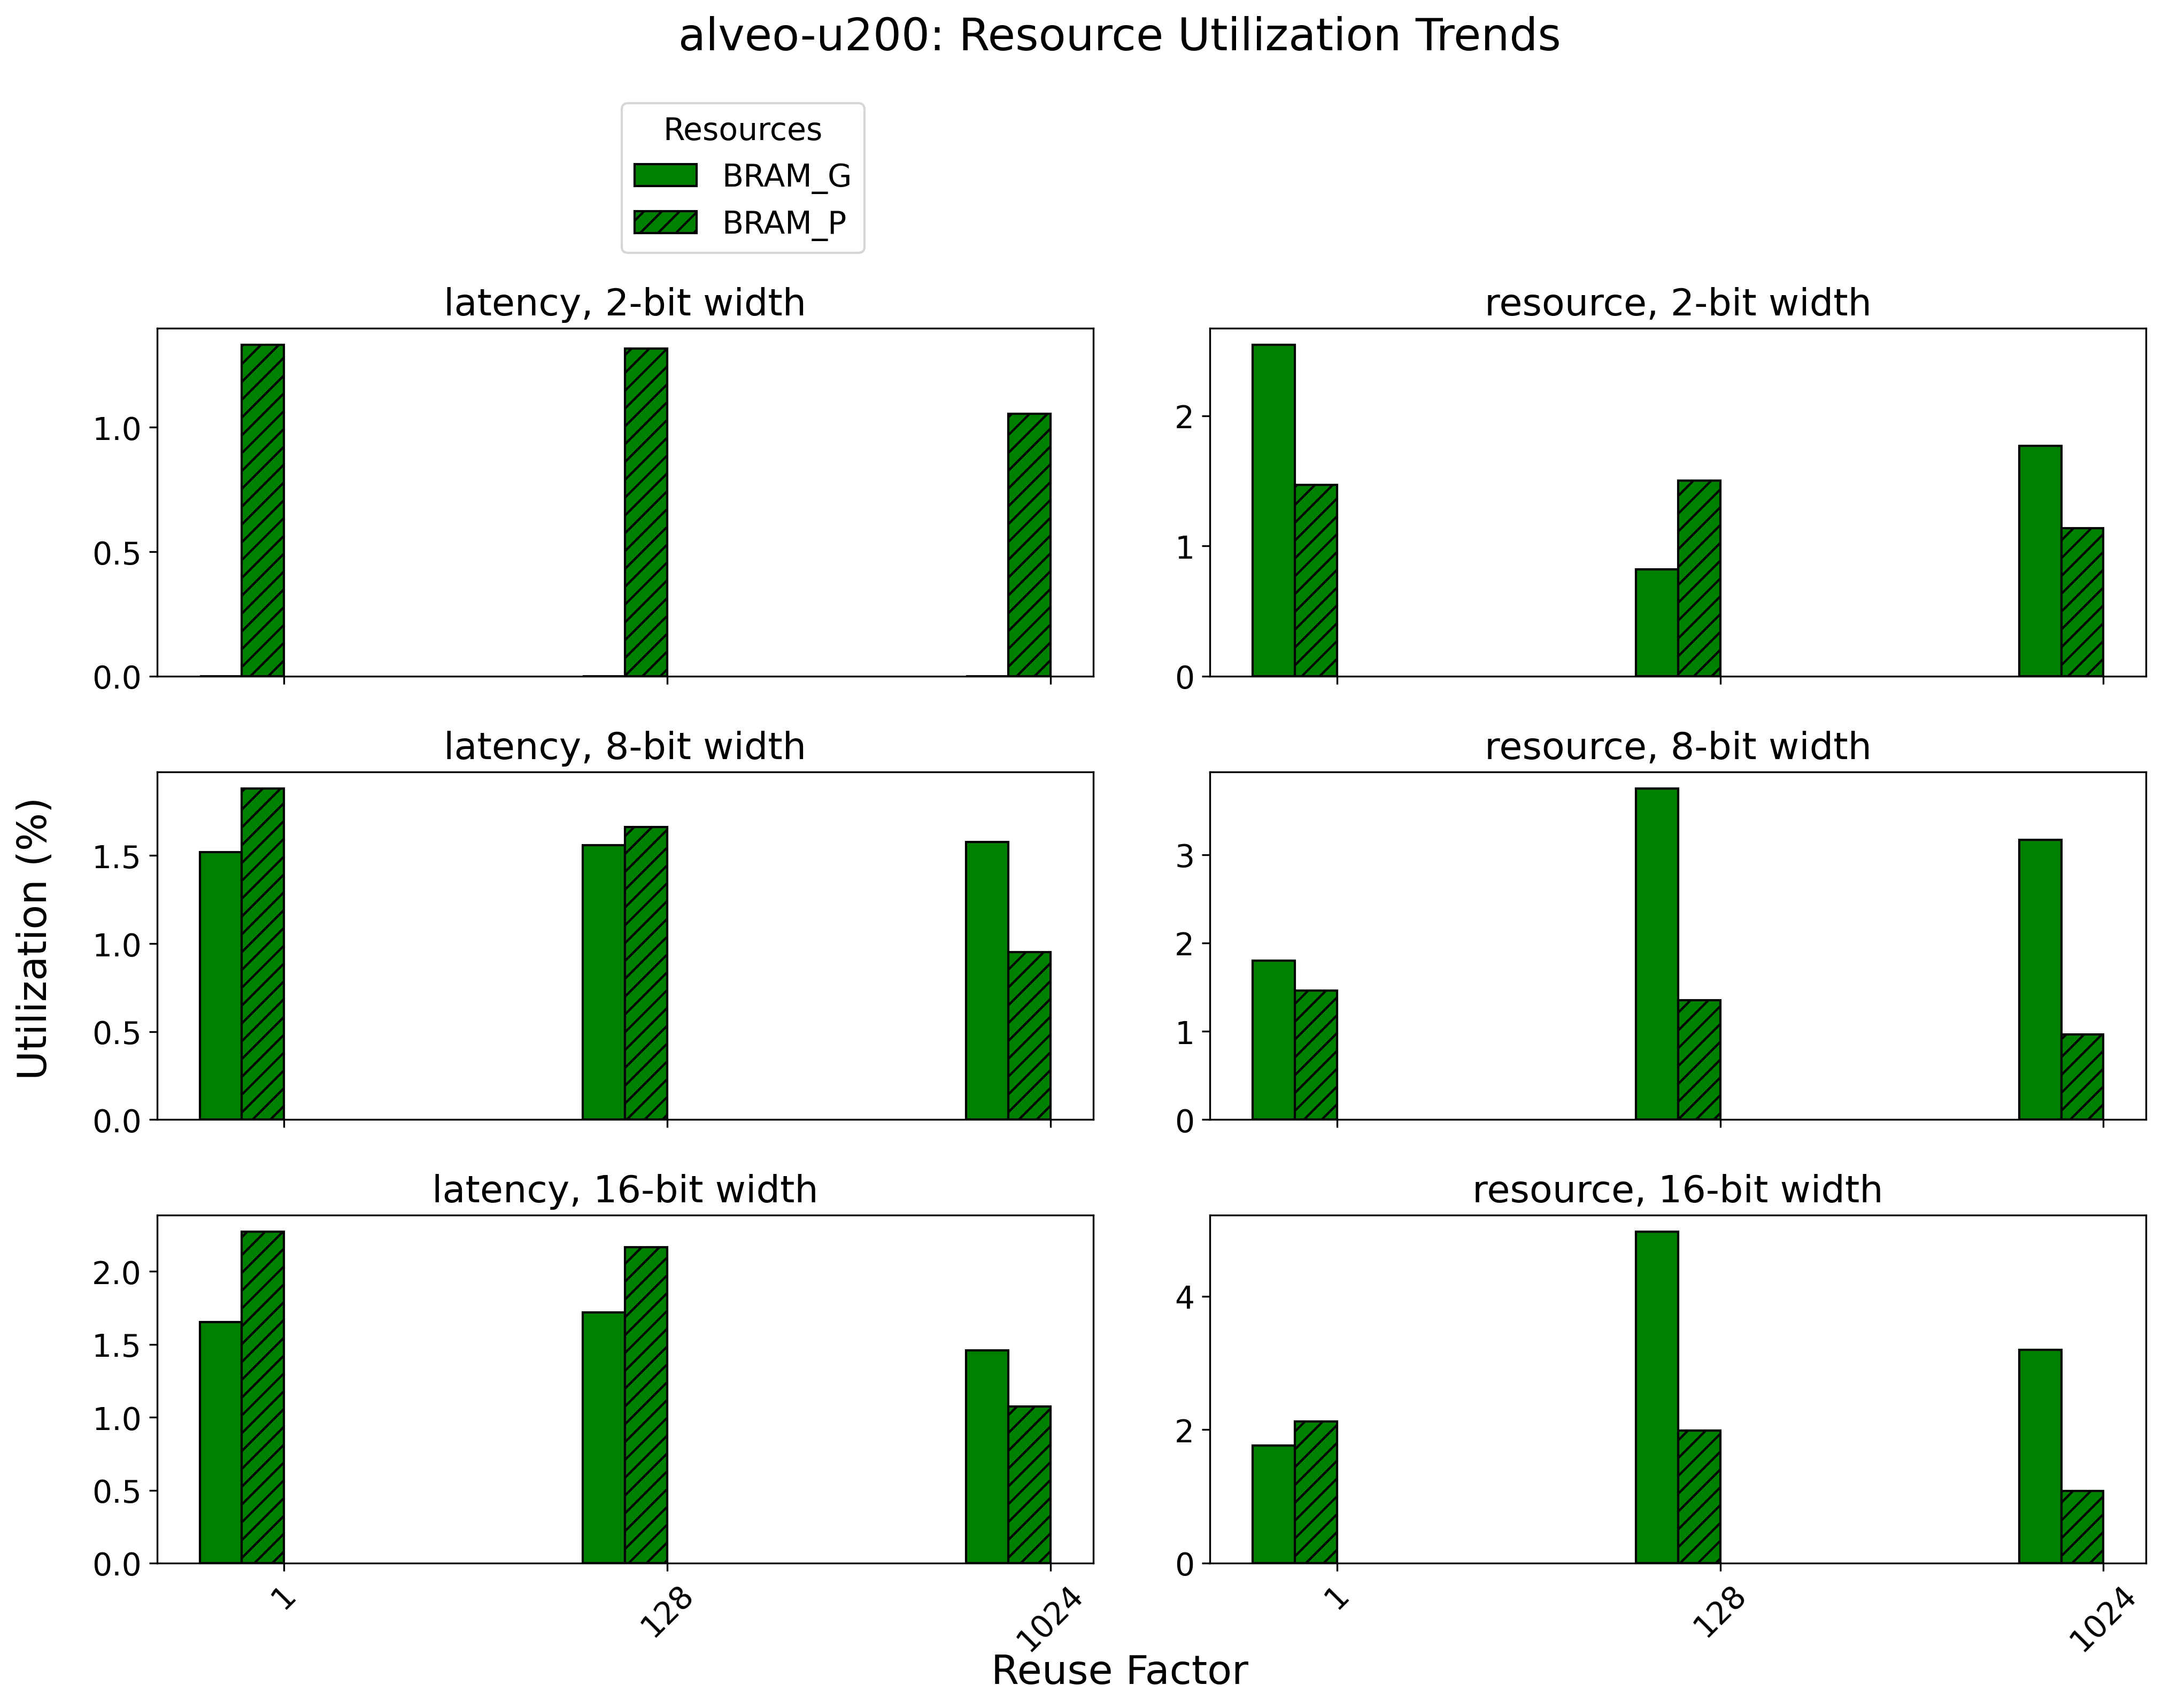

In [51]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})

board_name = "alveo-u200"
grouped = prediction_grouped_mean\
    .xs((board_name,), level=["board"]).groupby(["weight_total_bits", "strategy"])

unique_precisions = benchmark_merged_df["weight_total_bits"].unique()
unique_strategies = benchmark_merged_df["strategy"].unique()

n_cols = len(unique_strategies)
n_rows = len(unique_precisions)

fig, axes = plt.subplots(
    n_rows, n_cols, dpi=300, figsize=(16, 10), squeeze=False, sharex=True, sharey=False
)
axes = axes.flatten()

width = 0.11
colors = ["#008000", "#FF5964", "#17BEBB", "#FFA500"]
reuse_factors = sorted(benchmark_merged_df["global_reuse"].unique())
num_resources = 2
resource_gap = 0

total_width = num_resources * (2 * width + resource_gap) - resource_gap
start = np.arange(1, len(reuse_factors) + 1) - total_width / 2

row_idx = 0
col_idx = 0
for ax, ((precision, strategy), df) in zip(axes, grouped):
    for i, (col_gn, col_pred) in enumerate(zip(df.columns[::2], df.columns[1::2])):
        gn_vals = df[col_gn]
        pred_vals = df[col_pred]

        resource_indices = start + i * (2 * width + resource_gap)

        for j, reuse_factor in enumerate(reuse_factors):
            gn_label = ""
            pred_label = ""
            if j == 0:
                gn_label = f"{col_gn}"
                pred_label = f"{col_pred}"

            ax.bar(
                resource_indices[j] - width / 2,
                gn_vals[j],
                width,
                label=gn_label,
                color=colors[i % len(colors)],
                edgecolor="black",
            )
            ax.bar(
                resource_indices[j] + width / 2,
                pred_vals[j],
                width,
                label=pred_label,
                color=colors[i % len(colors)],
                edgecolor="black",
                hatch="///",
            )

    ax.set_title(f"{strategy}, {int(precision)}-bit width")
    ax.set_xticks(start + (num_resources - 1) * (width + resource_gap / 2))
    ax.set_xticklabels(reuse_factors, rotation=45)

    # if col_idx == 0:
    #     ax.set_ylabel("Utilization (%)")

    # if row_idx == n_rows - 1:
    #     ax.set_xlabel("Reuse Factor")

    col_idx += 1
    if col_idx == n_cols:
        row_idx += 1
        col_idx = 0

handles, labels = ax.get_legend_handles_labels()
legends = fig.legend(
    handles,
    labels,
    title="Resources",
    bbox_to_anchor=[0.3, 1.03],
    loc="upper left",
    # loc="upper right",
    ncol=len(labels) // 2,
)

xtext = fig.text(0.5, 0.035, "Reuse Factor", ha="center", size=18)
ytext = fig.text(0.07, 0.5, "Utilization (%)", va="center", rotation="vertical", size=18)

suptitle = fig.suptitle(f"{board_name}: Resource Utilization Trends", fontsize=20, y=1.075)

plt.subplots_adjust(hspace=0.275, wspace=0.125)
plt.show()

In [ ]:
from rule4ml.parsers.data_parser import (
    read_from_json,
    get_global_data,
    get_sequential_data,
    to_dataframe,
    default_strategy_map,
    default_board_map,
    default_layer_type_map,
)

benchmark_data = read_from_json("../datasets/benchmark_data.json")

benchmark_meta_data, benchmark_global_inputs, benchmark_targets = get_global_data(benchmark_data)
benchmark_sequential_inputs = get_sequential_data(benchmark_data)

global_categorical_maps = {
    "strategy": default_strategy_map,
    "board": default_board_map,
}
sequential_categorical_maps = {
    "layer_type": default_layer_type_map,
}

benchmark_df = to_dataframe(
    meta_data=benchmark_meta_data,
    global_inputs=benchmark_global_inputs,
    sequential_inputs=benchmark_sequential_inputs,
    global_categorical_maps={},
    sequential_categorical_maps={},
    targets=benchmark_targets,
)
benchmark_gn_df = benchmark_df[
    [
        "model_name",
        "board",
        "strategy",
        "precision",
        "global_reuse",
        "bram",
        "dsp",
        "ff",
        "lut",
        "cycles",
    ]
].copy()
benchmark_gn_df = benchmark_gn_df.rename(
    {
        "model_name": "Model",
        "board": "Board",
        "strategy": "Strategy",
        "precision": "Precision",
        "global_reuse": "Reuse Factor",
        "bram": "BRAM",
        "dsp": "DSP",
        "ff": "FF",
        "lut": "LUT",
        "cycles": "CYCLES",
    },
    axis=1,
)
benchmark_gn_df.loc[benchmark_gn_df["Strategy"] == "latency", "Strategy"] = "Latency"
benchmark_gn_df.loc[benchmark_gn_df["Strategy"] == "resource", "Strategy"] = "Resource"

benchmark_gn_df["BRAM"] = benchmark_gn_df["BRAM"].apply(lambda x: min(x, 200.0))
benchmark_gn_df["DSP"] = benchmark_gn_df["DSP"].apply(lambda x: min(x, 200.0))
benchmark_gn_df["FF"] = benchmark_gn_df["FF"].apply(lambda x: min(x, 200.0))
benchmark_gn_df["LUT"] = benchmark_gn_df["LUT"].apply(lambda x: min(x, 200.0))

precision_order = ["ap_fixed<2, 1>", "ap_fixed<8, 3>", "ap_fixed<16, 6>"]
benchmark_gn_df["Precision"] = pd.Categorical(
    benchmark_gn_df["Precision"], categories=precision_order, ordered=True
)

benchmark_gn_df.head(14)

In [ ]:
gn_grouped_mean = (
    benchmark_gn_df.groupby(["Strategy", "Board", "Precision", "Reuse Factor"])[
        [
            "BRAM",
            "DSP",
            "FF",
            "LUT",
            # "CYCLES"
        ]
    ]
    .mean()
    .round(0)
    .astype(int)
)

prediction_grouped_mean = (
    prediction_df.groupby(["Strategy", "Board", "Precision", "Reuse Factor"])[
        [
            "BRAM",
            "DSP",
            "FF",
            "LUT",
            # "CYCLES"
        ]
    ]
    .mean()
    .round(0)
    .astype(int)
)

In [ ]:
merged_df = pd.merge(
    gn_grouped_mean,
    prediction_grouped_mean,
    on=("Strategy", "Board", "Precision", "Reuse Factor"),
    suffixes=(" (G)", " (P)"),
)

merged_df = merged_df[
    [
        "BRAM (G)",
        "BRAM (P)",
        "DSP (G)",
        "DSP (P)",
        "FF (G)",
        "FF (P)",
        "LUT (G)",
        "LUT (P)",
        # "CYCLES (G)", "CYCLES (P)",
    ]
]
merged_df.head()

In [ ]:
import matplotlib.pyplot as plt
from rule4ml.parsers.utils import fixed_precision_to_bit_width

plt.rcParams.update({"font.size": 14})

grouped = merged_df.xs(("pynq-z2",), level=["Board"]).groupby(["Precision", "Strategy"])

n_groups = len(grouped)
n_cols = 2
n_rows = 3

fig, axes = plt.subplots(
    n_rows, n_cols, dpi=300, figsize=(16, 10), squeeze=False, sharex=True, sharey=False
)
axes = axes.flatten()

width = 0.11
colors = ["#008000", "#FF5964", "#17BEBB", "#FFA500"]
reuse_factors = prediction_df["Reuse Factor"].unique()
num_resources = 4
resource_gap = 0

total_width = num_resources * (2 * width + resource_gap) - resource_gap
start = np.arange(1, len(reuse_factors) + 1) - total_width / 2

row_idx = 0
col_idx = 0
for ax, ((precision, strategy), df) in zip(axes, grouped):
    for i, (col_gn, col_pred) in enumerate(zip(df.columns[::2], df.columns[1::2])):
        gn_vals = df[col_gn]
        pred_vals = df[col_pred]

        resource_indices = start + i * (2 * width + resource_gap)

        for j, reuse_factor in enumerate(reuse_factors):
            gn_label = ""
            pred_label = ""
            if j == 0:
                gn_label = f"{col_gn}"
                pred_label = f"{col_pred}"

            ax.bar(
                resource_indices[j] - width / 2,
                gn_vals[j],
                width,
                label=gn_label,
                color=colors[i % len(colors)],
                edgecolor="black",
            )
            ax.bar(
                resource_indices[j] + width / 2,
                pred_vals[j],
                width,
                label=pred_label,
                color=colors[i % len(colors)],
                edgecolor="black",
                hatch="///",
            )

    total_bits, fraction_bits = fixed_precision_to_bit_width(precision)

    ax.set_title(f"{strategy}, {total_bits}-bit width")
    ax.set_xticks(start + (num_resources - 1) * (width + resource_gap / 2))
    ax.set_xticklabels(reuse_factors, rotation=45)

    # if col_idx == 0:
    #     ax.set_ylabel("Utilization (%)")

    # if row_idx == n_rows - 1:
    #     ax.set_xlabel("Reuse Factor")

    col_idx += 1
    if col_idx == n_cols:
        row_idx += 1
        col_idx = 0

handles, labels = ax.get_legend_handles_labels()
legends = fig.legend(
    handles,
    labels,
    title="Resources",
    bbox_to_anchor=[0.3, 1.03],
    loc="upper left",
    # loc="upper right",
    ncol=len(labels) // 2,
)

xtext = fig.text(0.5, 0.035, "Reuse Factor", ha="center", size=18)
ytext = fig.text(0.07, 0.5, "Utilization (%)", va="center", rotation="vertical", size=18)

suptitle = fig.suptitle("Pynq-Z2: Resource Utilization Trends", fontsize=20, y=1.075)

plt.subplots_adjust(hspace=0.275, wspace=0.125)
plt.show()

# fig.savefig(
#     "/mnt/c/Users/Y540/Desktop/pynq_avg_bars.jpg",
#     dpi=300,
#     bbox_extra_artists=(legends, xtext, ytext, suptitle),
#     bbox_inches="tight",
# )

In [ ]:
plt.rcParams.update({"font.size": 14})

grouped = merged_df.xs(("zcu102",), level=["Board"]).groupby(["Precision", "Strategy"])

n_groups = len(grouped)
n_cols = 2
n_rows = 3

fig, axes = plt.subplots(
    n_rows, n_cols, dpi=300, figsize=(16, 10), squeeze=False, sharex=True, sharey=False
)
axes = axes.flatten()

width = 0.11
colors = ["#008000", "#FF5964", "#17BEBB", "#FFA500"]
reuse_factors = prediction_df["Reuse Factor"].unique()
num_resources = 4
resource_gap = 0

total_width = num_resources * (2 * width + resource_gap) - resource_gap
start = np.arange(1, len(reuse_factors) + 1) - total_width / 2

row_idx = 0
col_idx = 0
for ax, ((precision, strategy), df) in zip(axes, grouped):
    for i, (col_gn, col_pred) in enumerate(zip(df.columns[::2], df.columns[1::2])):
        gn_vals = df[col_gn]
        pred_vals = df[col_pred]

        resource_indices = start + i * (2 * width + resource_gap)

        for j, reuse_factor in enumerate(reuse_factors):
            gn_label = ""
            pred_label = ""
            if j == 0:
                gn_label = f"{col_gn}"
                pred_label = f"{col_pred}"

            ax.bar(
                resource_indices[j] - width / 2,
                gn_vals[j],
                width,
                label=gn_label,
                color=colors[i % len(colors)],
                edgecolor="black",
            )
            ax.bar(
                resource_indices[j] + width / 2,
                pred_vals[j],
                width,
                label=pred_label,
                color=colors[i % len(colors)],
                edgecolor="black",
                hatch="///",
            )

    total_bits, fraction_bits = fixed_precision_to_bit_width(precision)

    ax.set_title(f"{strategy}, {total_bits}-bit width")
    ax.set_xticks(start + (num_resources - 1) * (width + resource_gap / 2))
    ax.set_xticklabels(reuse_factors, rotation=45)

    col_idx += 1
    if col_idx == n_cols:
        row_idx += 1
        col_idx = 0

handles, labels = ax.get_legend_handles_labels()
legends = fig.legend(
    handles,
    labels,
    title="Resources",
    bbox_to_anchor=[0.3, 1.03],
    loc="upper left",
    ncol=len(labels) // 2,
)

xtext = fig.text(0.5, 0.035, "Reuse Factor", ha="center", size=18)
ytext = fig.text(0.07, 0.5, "Utilization (%)", va="center", rotation="vertical", size=18)

suptitle = fig.suptitle("ZCU102: Resource Utilization Trends", fontsize=20, y=1.075)

plt.subplots_adjust(hspace=0.275, wspace=0.125)
plt.show()

# fig.savefig(
#     "/mnt/c/Users/Y540/Desktop/zcu_avg_bars.jpg",
#     dpi=300,
#     bbox_extra_artists=(legends, xtext, ytext, suptitle),
#     bbox_inches="tight",
# )

In [ ]:
gn_grouped_mean = (
    benchmark_gn_df.groupby(["Strategy", "Board", "Precision", "Reuse Factor"])[["CYCLES"]]
    .mean()
    .round(0)
    .astype(int)
)

prediction_grouped_mean = (
    prediction_df.groupby(["Strategy", "Board", "Precision", "Reuse Factor"])[["CYCLES"]]
    .mean()
    .round(0)
    .astype(int)
)

merged_df = pd.merge(
    gn_grouped_mean,
    prediction_grouped_mean,
    on=("Strategy", "Board", "Precision", "Reuse Factor"),
    suffixes=(" (G)", " (P)"),
)

merged_df = merged_df[
    [
        "CYCLES (G)",
        "CYCLES (P)",
    ]
]
merged_df.head()

plt.rcParams.update({"font.size": 14})

grouped = merged_df.groupby(["Board", "Strategy", "Precision"])

n_groups = len(grouped)
n_cols = 3
n_rows = (n_groups // n_cols) + (n_groups % n_cols > 0)

fig, axes = plt.subplots(
    n_rows, n_cols, dpi=300, figsize=(16, 10), squeeze=False, sharex=True, sharey=False
)
axes = axes.flatten()

width = 0.35
colors = ["#17BEBB", "#FFA500"]
reuse_factors = prediction_df["Reuse Factor"].unique()
num_resources = 1
resource_gap = 0

total_width = num_resources * (2 * width + resource_gap) - resource_gap
start = np.arange(1, len(reuse_factors) + 1) - total_width / 2

row_idx = 0
col_idx = 0
for ax, ((board, strategy, precision), df) in zip(axes, grouped):
    for i, (col_gn, col_pred) in enumerate(zip(df.columns[::2], df.columns[1::2])):
        gn_vals = df[col_gn]
        pred_vals = df[col_pred]

        resource_indices = start + i * (2 * width + resource_gap)

        for j, reuse_factor in enumerate(reuse_factors):
            gn_label = ""
            pred_label = ""
            if j == 0:
                gn_label = f"{col_gn}"
                pred_label = f"{col_pred}"

            ax.bar(
                resource_indices[j] - width / 2,
                gn_vals[j],
                width,
                label=gn_label,
                color=colors[i % len(colors)],
                edgecolor="black",
            )
            ax.bar(
                resource_indices[j] + width / 2,
                pred_vals[j],
                width,
                label=pred_label,
                color=colors[i % len(colors) + 1],
                edgecolor="black",
                hatch="///",
            )

    total_bits, fraction_bits = fixed_precision_to_bit_width(precision)

    ax.set_title(f"{board}, {strategy}, {total_bits}-bit width")
    ax.set_xticks(start + (num_resources - 1) * (width + resource_gap / 2))
    ax.set_xticklabels(reuse_factors, rotation=45)

    col_idx += 1
    if col_idx == n_cols:
        row_idx += 1
        col_idx = 0

handles, labels = ax.get_legend_handles_labels()
legends = fig.legend(handles, labels, bbox_to_anchor=[0.8, 1], loc="upper left")

xtext = fig.text(0.5, 0.05, "Reuse Factor", ha="center", size=18)
ytext = fig.text(0.07, 0.5, "Cycles", va="center", rotation="vertical", size=18)

fig.suptitle("Clock Cycle Trends", fontsize=20)

plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

# fig.savefig(
#     "/mnt/c/Users/Y540/Desktop/cycles_avg_bars.jpg",
#     dpi=300,
#     bbox_extra_artists=(legends, xtext, ytext),
#     bbox_inches="tight",
# )